In [24]:
import numpy as np
import pandas as pd
import pickle
#from build_database import flux_obj
from scipy import interpolate
import matplotlib.pyplot as plt
import os
import itertools
import random
import os
import time
import datetime as dt

D2R = (np.pi/180.0)
R2D = 1.0/D2R
from spacepy import coordinates as coord
from spacepy.time import Ticktock

from raytracer_utils import readdump, read_rayfile, read_rayfiles, read_damp
from mpl_toolkits.mplot3d import Axes3D

from mpl_toolkits.axes_grid1 import make_axes_locatable


#%matplotlib inline
%matplotlib nbagg
# Autoload changes made in external editor:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<IPython.core.display.Javascript object>


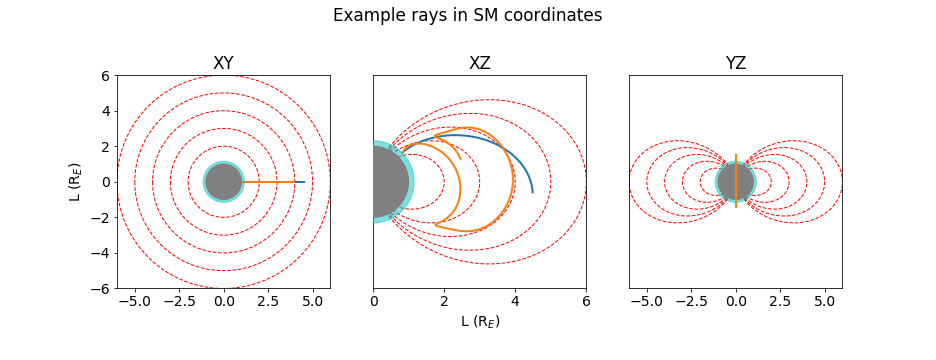

Text(0.5, 0.98, 'Example rays in SM coordinates')

In [25]:
# Load n' plot the Ngo files:
project_root = os.getcwd();
ray_out_dir = os.path.join(project_root, "test_outputs");

# Load all the rayfiles in the output directory
d = os.listdir(ray_out_dir)
file_titles = [x[:-4] for x in d if x.endswith('.ray')]

raylist = []
damplist= []

for r in file_titles:
    raylist += read_rayfile(os.path.join(ray_out_dir,r + '.ray'))
    damplist+= read_damp(os.path.join(ray_out_dir,r + '.damp'))



# --------------- Latex Plot Beautification --------------------------
fig_width_pt = 650.0  # Get this from LaTeX using \showthe\columnwidth
inches_per_pt = 1.0/72.27               # Convert pt to inch
golden_mean = (np.sqrt(5)-1.0)/2.0         # Aesthetic ratio
fig_width = 12  # width in inches
fig_height = 4      # height in inches
fig_size =  [fig_width+1,fig_height+1]
params = {'backend': 'ps',
          'axes.labelsize': 14,
          'font.size': 14,
          'legend.fontsize': 14,
          'xtick.labelsize': 14,
          'ytick.labelsize': 14,
          'text.usetex': False,
          'figure.figsize': fig_size}
plt.rcParams.update(params)
# --------------- Latex Plot Beautification --------------------------

R_E = 6371e3
H_IONO=1000e3

flashtime = dt.datetime(2010,1,1,0,0,0)

# Put the rays into a friendly system (and so we can use coordinate transforms)
rays = []
for r in raylist:
    tmp_coords = coord.Coords(list(zip(r['pos'].x, r['pos'].y, r['pos'].z)),'SM','car',units=['m','m','m'])
    tvec_datetime = [flashtime + dt.timedelta(seconds=s) for s in r['time']]
    tmp_coords.ticks = Ticktock(tvec_datetime) # add ticks
    
    # Convert to whatever output coordinate system you'd like to plot!
    # Here's how to switch to Cartesian magnetic dipole.
#     tmp_coords = tmp_coords.convert('MAG','car')

    tmp_coords.sim_time = r['time']
    rays.append(tmp_coords)



psize = 6    # plot size in earth radii
L_shells = [2, 3, 4, 5, 6]    # Field lines to draw

fig, ax = plt.subplots(1,3)

# Plot the earth
for i in [0, 1, 2]:
    earth = plt.Circle((0,0),1,color='0.5',alpha=1, zorder=100)
    iono  = plt.Circle((0,0),(R_E + H_IONO)/R_E, color='c',alpha=0.5, zorder=99)
    ax[i].add_patch(earth)   
    ax[i].add_patch(iono)
    
    
# Plot the fieldlines (dipole model; could use something more complex)
for L in L_shells:
    # Plot dipole field lines for both profile views
    lam = np.linspace(-80,80,181)
    L_r = L*pow(np.cos(lam*D2R),2)
    Lx  = L_r*np.cos(lam*D2R)
    Ly  = L_r*np.sin(lam*D2R)
    ax[1].plot(Lx,Ly,color='r',linewidth=1,linestyle='dashed')   # Field line
    ax[2].plot(Lx,Ly,color='r',linewidth=1,linestyle='dashed')   # Field line
    ax[2].plot(-Lx,Ly,color='r',linewidth=1,linestyle='dashed')  # Field line (other side)
    
    # Plot equatorial extent for the top-down view
    lam = np.linspace(-180,180,181)
    Lx2  = L*np.cos(lam*D2R)
    Ly2  = L*np.sin(lam*D2R)
    ax[0].plot(Lx2,Ly2,color='r',linewidth=1,linestyle='dashed')
    
# Plot rays:
lw = 2 # linewidth
for r in rays:
    ax[0].plot(r.x/R_E, r.y/R_E, linewidth=lw)
    if r.y[0] < 0:
        ax[1].plot(r.x/R_E, r.z/R_E, linewidth=lw, zorder=101)
    else:
        ax[1].plot(r.x/R_E, r.z/R_E, linewidth=lw, zorder=10)
    if r.x[0] > 0:
        ax[2].plot(r.y/R_E, r.z/R_E, linewidth=lw, zorder=101)
    else:
        ax[2].plot(r.y/R_E, r.z/R_E, linewidth=lw, zorder=10)

# Set limits
ax[0].set_title('XY')
ax[1].set_title('XZ')
ax[2].set_title('YZ')
ax[1].set_yticks([])
ax[2].set_yticks([])

ax[1].set_xlabel('L (R$_E$)')
ax[0].set_ylabel('L (R$_E$)')

ax[0].set_xlim([-psize, psize])
ax[0].set_ylim([-psize, psize])
ax[1].set_xlim([0, psize])
ax[1].set_ylim([-psize/2, psize/2])
ax[2].set_xlim([-psize, psize])
ax[2].set_ylim([-psize, psize])

ax[0].set_aspect('equal')
ax[1].set_aspect('equal')
ax[2].set_aspect('equal')

fig.suptitle('Example rays in SM coordinates')

In [32]:
tmp_coords = coord.Coords(list(zip(r['pos'].x, r['pos'].y, r['pos'].z)),'SM','car',units=['m','m','m'])



In [ ]:
# Things to look at (thursday nite)
#   - Try the full GCPM and compare with your simple model (HELLA SLOW)
#   - Plot damping codes -- HEY you only got like 5 minutes into this, so do it
#   - Try raytracer with the grid-sampled models, they will be useful to people
#   - Get plasmasphere dumps for each model, and plot them too